In [ ]:
#####################################################################################
# Audio-driven upper-body motion synthesis on a humanoid robot
# Computer Science Tripos Part III Project
# Jan Ondras (jo356@cam.ac.uk), Trinity College, University of Cambridge
# 2017/18
#####################################################################################
# Investigation of the effect of dropout regularisation on the MLP-SI model performance
#####################################################################################

In [ ]:
#######################################################################################################
# Baseline MLP (assuming independence between timesteps)
# Subject-independent
# Training set is shuffled! (by Keras)
#######################################################################################################
# Using chosen feature set & its optimal architecture, evaluate effect of dropout
# Train & test on validation set
#######################################################################################################
#######################################################################################################
# EVALUATE ON VALIDATION SET only
#######################################################################################################
# Train 2 more models, checkpoint

import numpy as np
import time
import glob

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from geoutils import radToDeg, degToRad
from evalutils import get_global_cca, get_local_cca, eval_test, norm_Y, inv_norm_Y, plot_predictions

# DROPOUT PROBABILITIES
dropouts = [0.25, 0.5]

SEGMENT_LEN = 300 # for evaluation (local cca)

AF_type = 'AF_logFB26_norm'
tuning_type = '1_35_AF26'

TE_folder = 'TrainingExamples_16kHz'
save_results_path_prefix = './../Dataset/'+TE_folder+'/Results/MLP_SI/XXX' 
model_checkpoint_path_prefix = './ModelCheckpoints/MLP_SI/'
print TE_folder, AF_type, tuning_type

np.random.seed(37) # for reproducibility
unique_srt_VIDs = unique_srt_VIDs = np.load('./../Dataset/'+TE_folder+'/te_unique_srt_VIDs.npz')['unique_srt_VIDs'] # sorted VIDs
all_srt_VIDs = np.load('./../Dataset/'+TE_folder+'/te_VIDs.npz')['VIDs']
unique_srt_SIDs = np.array([x[:5] for i, x in enumerate(unique_srt_VIDs) if i % 2 == 0]) # ['PID02', 'PID05', ..
PF = np.load('./../Dataset/'+TE_folder+'/te_PF_smooth_LPBF_4.0.npz')['PF_smooth_LPBF']
PF = PF[:, :11]
N_targets = PF.shape[1]
###########
# Target (Y) normalisation, into range 0-1 according to constraints
PF = norm_Y(PF)
print "Targets (Y) are TRANSFORMED to 0-1 range"

#######################
# Load the dataset split  
ds = np.load('./../Dataset/'+TE_folder+'/Dataset_split/split_masks_all.npz')
train_mask = ds['train_mask']
val_mask   = ds['val_mask']
val_VIDs  = ds['val_VIDs']
val_VIDs_ind_cnts = ds['val_VIDs_ind_cnts']

Y_train = PF[train_mask]
Y_val   = PF[val_mask]

FPS = 100.

# Learning settings
epochs = 1000

st = time.time()

for dropout in dropouts:

    if tuning_type[-2:] != AF_type.split('_')[1][-2:]:
        raise ValueError("Tuning type and audio feature type mismatch!")

    #######################################################################################################
    AF = np.load('./../Dataset/'+TE_folder+'/te_'+AF_type+'.npz')[AF_type]
    N_features = AF.shape[1]

    X_train = AF[train_mask]
    X_val   = AF[val_mask]
    del AF

    #######################
    # Load validation data
    dd = np.load(save_results_path_prefix + 'val_' + tuning_type + '.npz')
    best_N_hl = int(dd['best_N_hl'])
    best_N_hu = int(dd['best_N_hu'])    
    print "\tOptimal number of hidden layers / hidden units: ", best_N_hl, " / ", best_N_hu

    train_batch_size = len(X_train)
    val_batch_size = len(X_val)

    ##########################
    # Final train & test

    # Create model
    model = Sequential()
    model.add(Dense(best_N_hu, activation='relu', kernel_initializer='he_uniform', input_dim=N_features))
    model.add(Dropout(dropout))
    for i in range(1, best_N_hl):
        model.add(Dense(best_N_hu, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(dropout))
    model.add(Dense(N_targets, activation='sigmoid'))

    model.compile(loss='mean_squared_error', optimizer=Adam())
    print model.summary()
    print "#parameters: ", model.count_params()
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1) # stop after 10 epochs without improvement in val_acc

    # Checkpoint model weights and the model itself: at each epoch
    model_checkpoint_name = 'm_DROP_{:.2f}'.format(dropout) + '_{epoch:04d}_{loss:.4f}_{val_loss:.4f}.hdf5'
    model_checkpoint = ModelCheckpoint(model_checkpoint_path_prefix + tuning_type + '/' + model_checkpoint_name, monitor='val_loss', 
                                       verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    
    hist = model.fit(X_train, Y_train, epochs=epochs, batch_size=train_batch_size, 
               validation_data = (X_val, Y_val), verbose=1, callbacks=[early_stop,model_checkpoint])

    print "\tTime taken: ", time.time()-st, (time.time()-st)/60. 

    Y_val_pred = model.predict(X_val, batch_size=val_batch_size, verbose=1)

    ###############################################################################################################
    # Save results: predictions will be saved in radians; for generation on robot
    # Raw and smoothed (low-pass 4Hz)
    from postprocessingutils import save_predictions_and_eval
    save_predictions_and_eval(save_results_path_prefix + 'MSDROPvaltest_' + tuning_type + '_{:.2f}'.format(dropout), 
                     X_val, Y_val, Y_val_pred, 'MLP_SI', SEGMENT_LEN, val_VIDs, val_VIDs_ind_cnts, 
                             N_params=model.count_params(), N_epochs=len(hist.history['loss']))
    
    print "\tTime taken: ", time.time()-st, (time.time()-st)/60. 
    
    #Time taken:  1076.26332712 17.9377226671

In [ ]:
#######################################################################################################
# Re-Evaluate on VALIDATION SET using BEST MODEL
# DONE
#######################################################################################################

from keras.models import load_model

model_names = [
    'm_DROP_0.25_0594_0.0175_0.0180.hdf5',
    'm_DROP_0.50_0675_0.0225_0.0182.hdf5'
]

dropouts = [0.25, 0.5]

SEGMENT_LEN = 300 # for evaluation (local cca)

AF_type = 'AF_logFB26_norm'
tuning_type = '1_35_AF26'

TE_folder = 'TrainingExamples_16kHz'
save_results_path_prefix = './../Dataset/'+TE_folder+'/Results/MLP_SI/XXX' 
model_checkpoint_path_prefix = './ModelCheckpoints/MLP_SI/'
print TE_folder, AF_type, tuning_type

np.random.seed(37) # for reproducibility
unique_srt_VIDs = unique_srt_VIDs = np.load('./../Dataset/'+TE_folder+'/te_unique_srt_VIDs.npz')['unique_srt_VIDs'] # sorted VIDs
all_srt_VIDs = np.load('./../Dataset/'+TE_folder+'/te_VIDs.npz')['VIDs']
unique_srt_SIDs = np.array([x[:5] for i, x in enumerate(unique_srt_VIDs) if i % 2 == 0]) # ['PID02', 'PID05', ..
PF = np.load('./../Dataset/'+TE_folder+'/te_PF_smooth_LPBF_4.0.npz')['PF_smooth_LPBF']
PF = PF[:, :11]
N_targets = PF.shape[1]
###########
# Target (Y) normalisation, into range 0-1 according to constraints
PF = norm_Y(PF)
print "Targets (Y) are TRANSFORMED to 0-1 range"

#######################
# Load the dataset split  
ds = np.load('./../Dataset/'+TE_folder+'/Dataset_split/split_masks_all.npz')
val_mask   = ds['val_mask']
val_VIDs  = ds['val_VIDs']
val_VIDs_ind_cnts = ds['val_VIDs_ind_cnts']

Y_val   = PF[val_mask]

st = time.time()
for dropout,model_name in zip(dropouts, model_names):

    if tuning_type[-2:] != AF_type.split('_')[1][-2:]:
        raise ValueError("Tuning type and audio feature type mismatch!")

    #######################################################################################################
    AF = np.load('./../Dataset/'+TE_folder+'/te_'+AF_type+'.npz')[AF_type]
    N_features = AF.shape[1]

    X_val   = AF[val_mask]
    del AF
    
    val_batch_size = len(X_val)

    #######################
    # Load best model
    test_model_name = model_checkpoint_path_prefix + tuning_type + '/' + model_name
    print "Loading BEST model from:", test_model_name
    model = load_model(test_model_name)

    ###############################################################################################################
    # Evaluate on validation set
    Y_val_pred = model.predict(X_val, batch_size=val_batch_size, verbose=1)

    # Save results: predictions will be saved in radians; for generation on robot
    # Raw and smoothed (low-pass 4Hz)
    from postprocessingutils import save_predictions_and_eval
    save_predictions_and_eval(save_results_path_prefix + 'MSBMDROPvaltest_' + tuning_type + '_{:.2f}'.format(dropout),
                     X_val, Y_val, Y_val_pred, 'MLP_SI', SEGMENT_LEN, val_VIDs, val_VIDs_ind_cnts, 
                             N_params=model.count_params())

    print "\tTime taken: ", time.time()-st, (time.time()-st)/60. 
    

DROPOUT:  0.0
===========================================Smooth=====================


PID20Task3


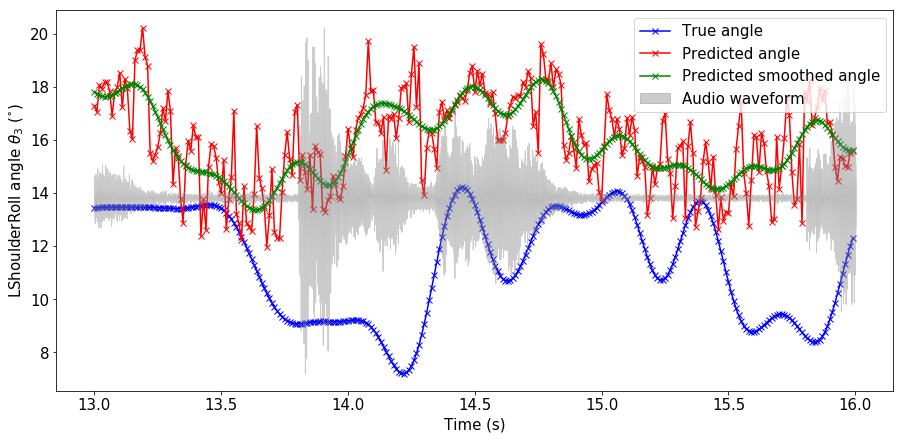

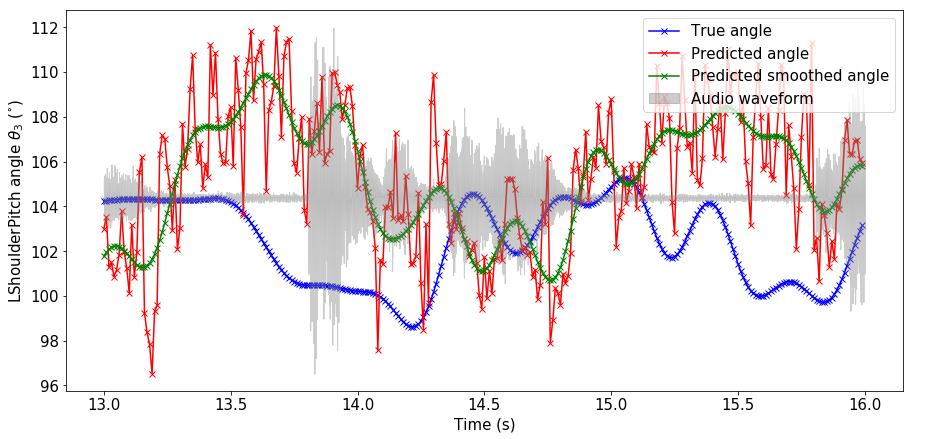

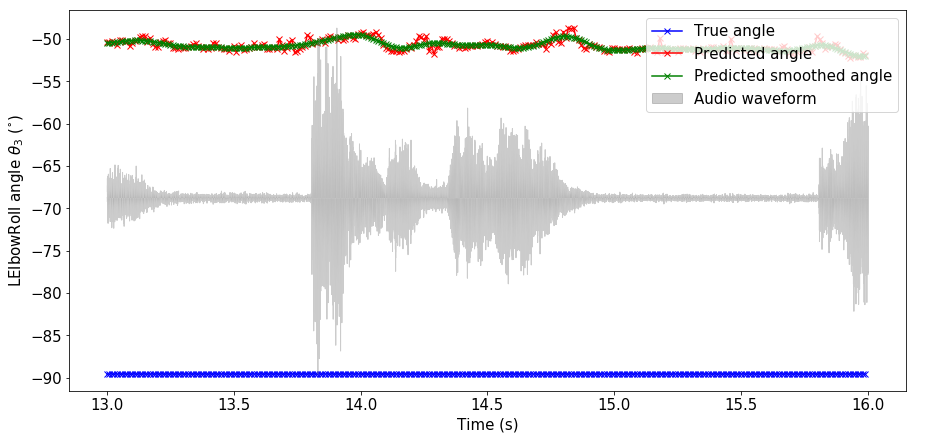

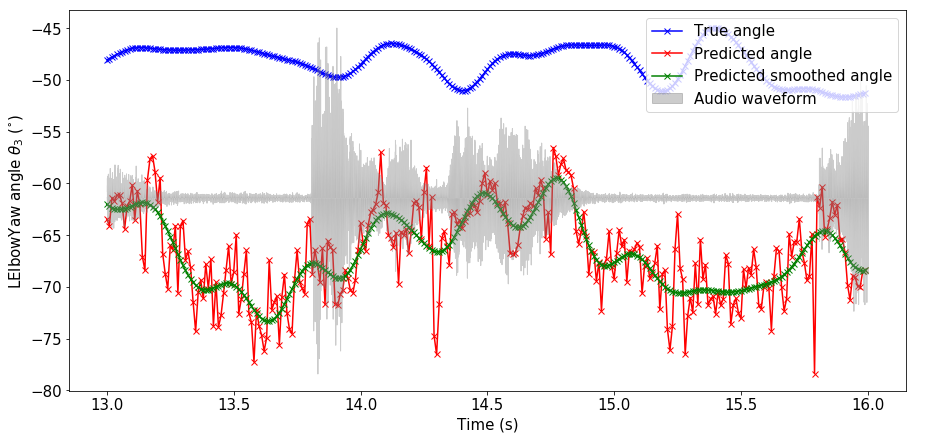

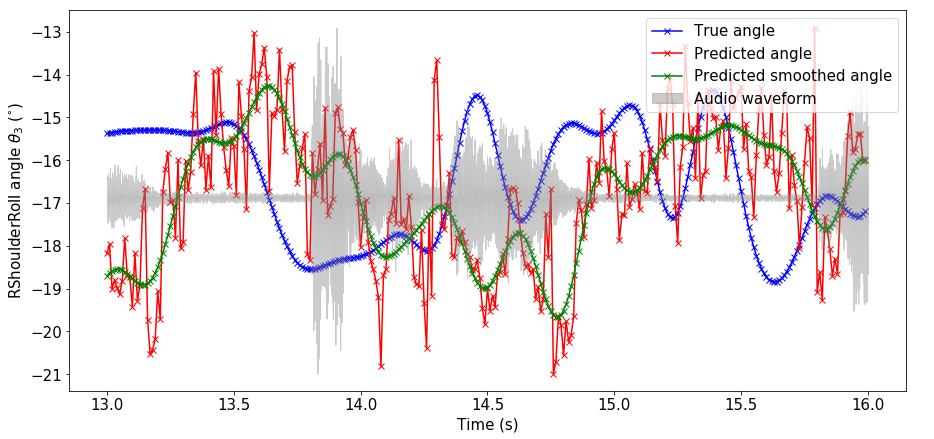

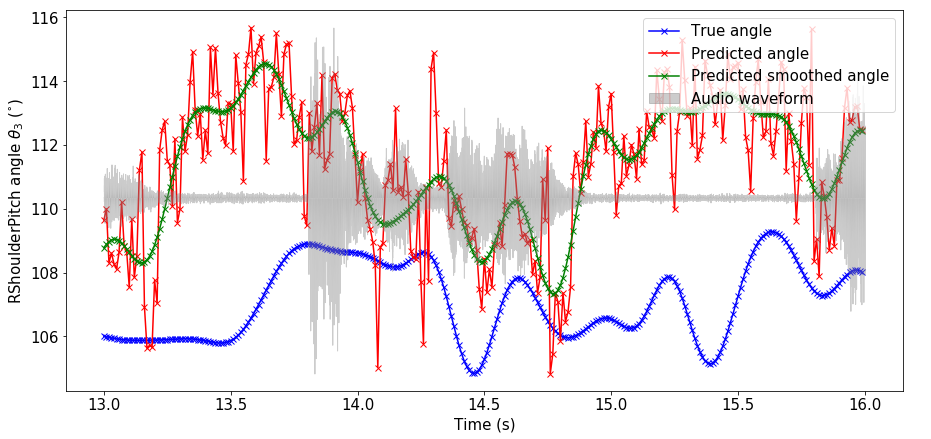

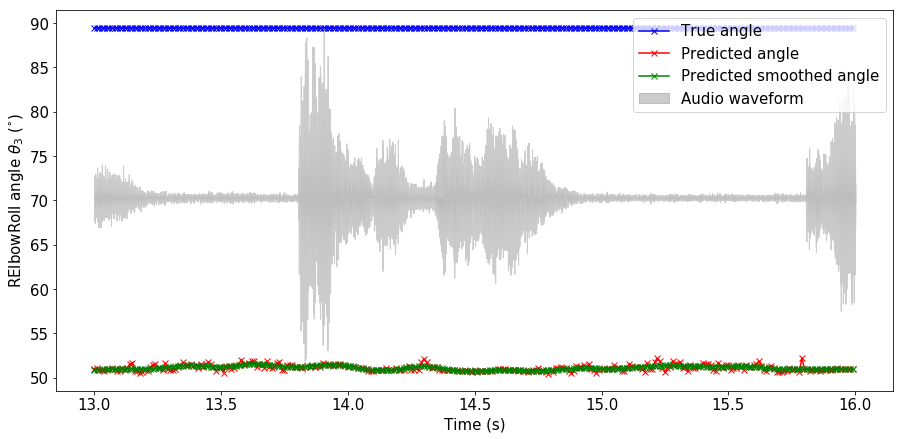

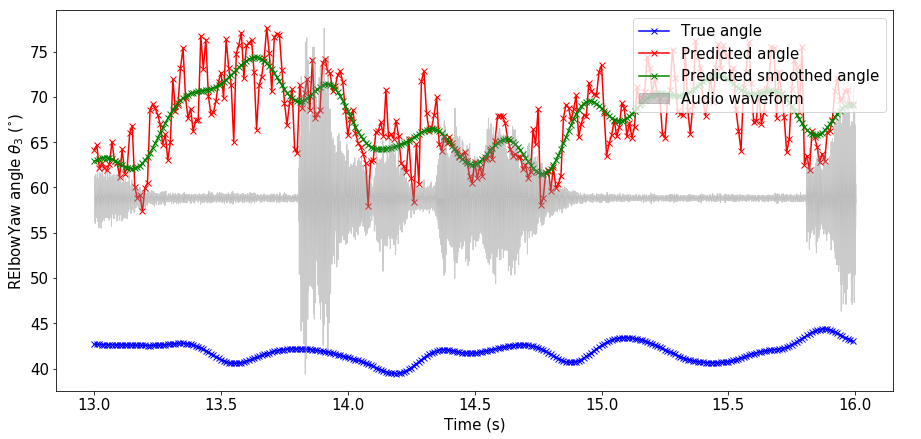

DROPOUT:  0.25
===========================================Smooth=====================


PID20Task3


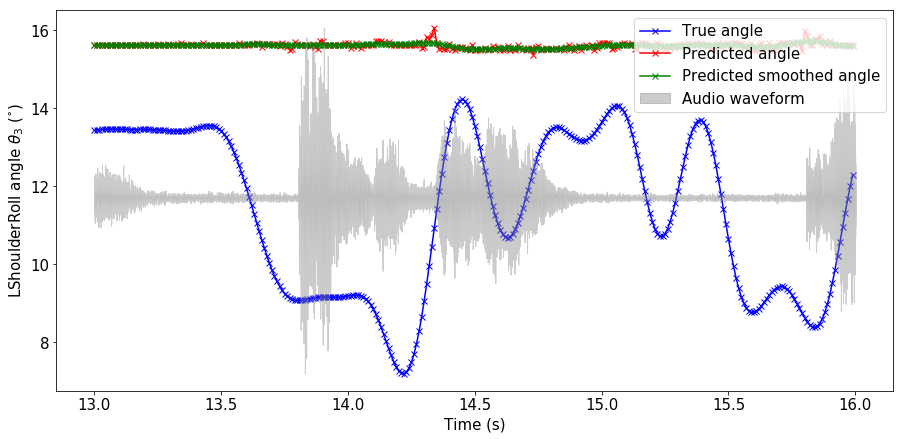

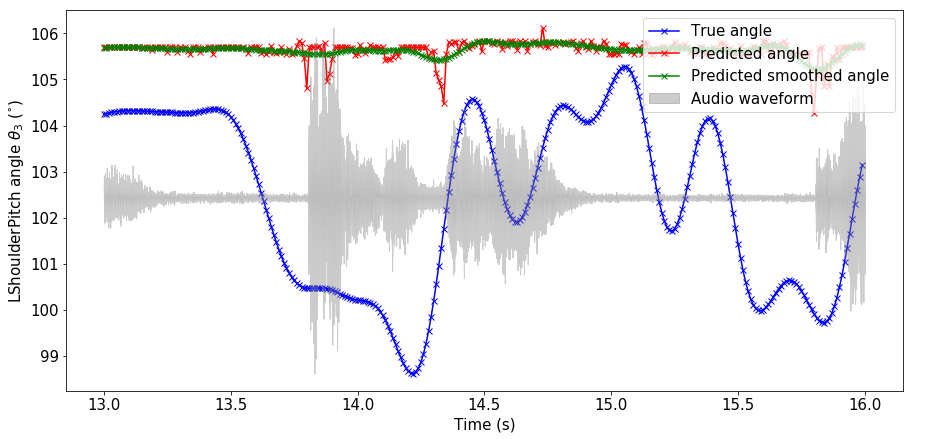

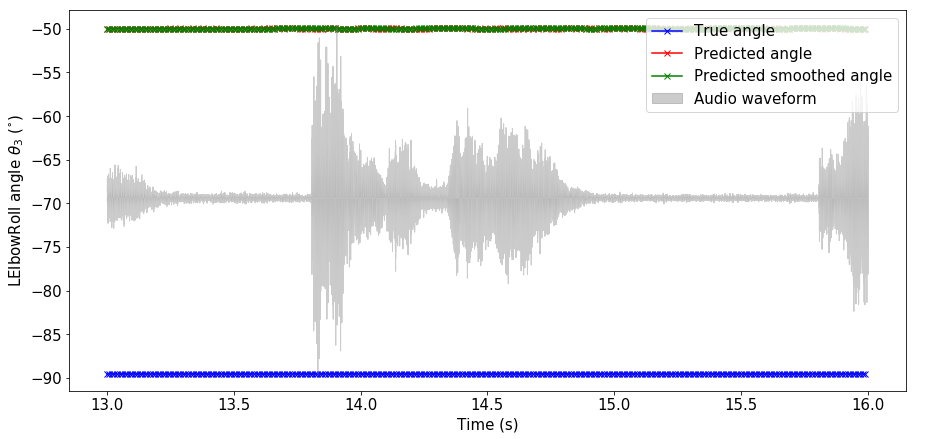

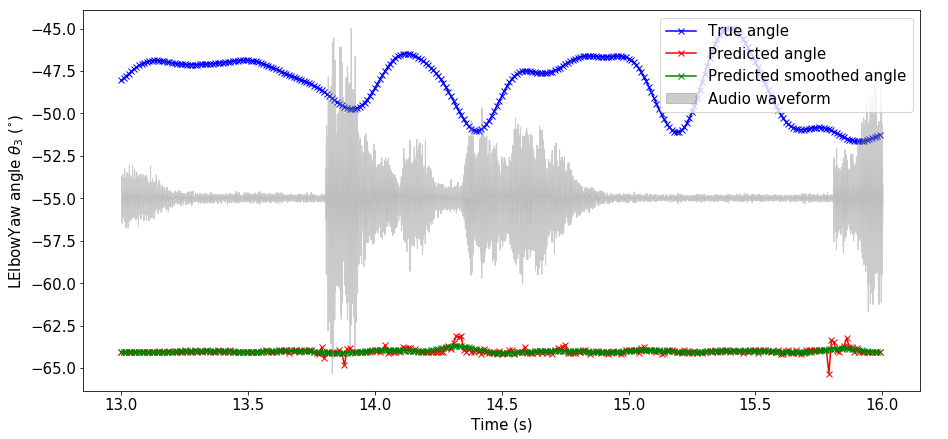

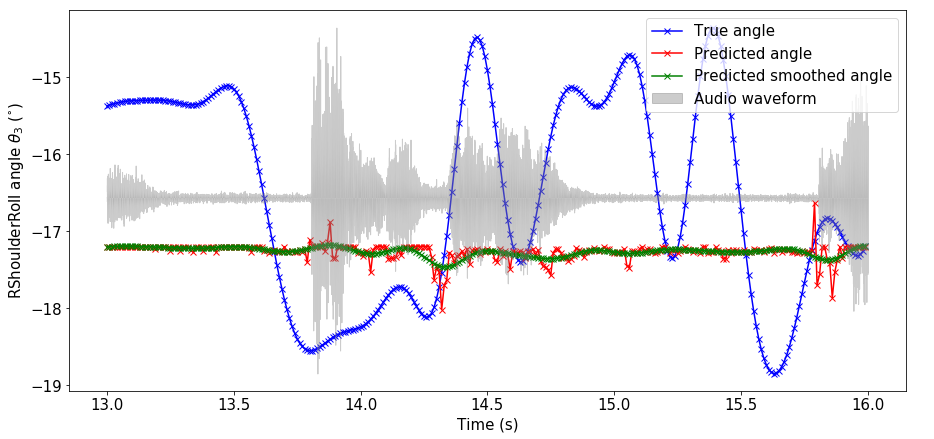

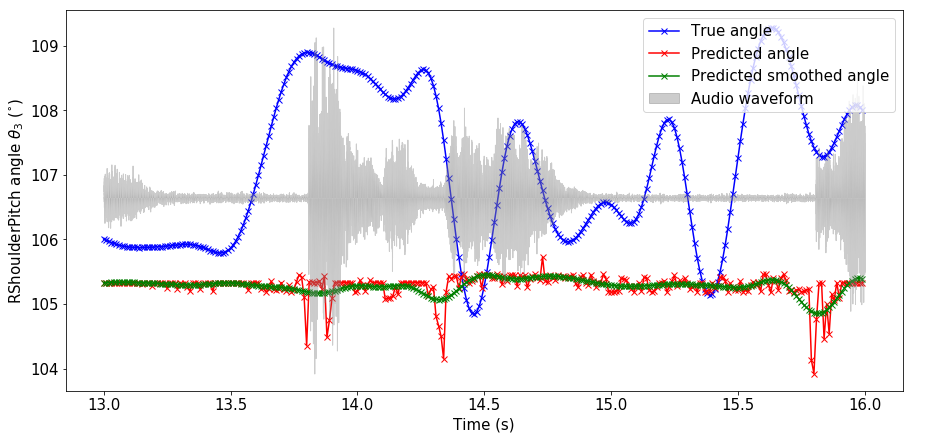

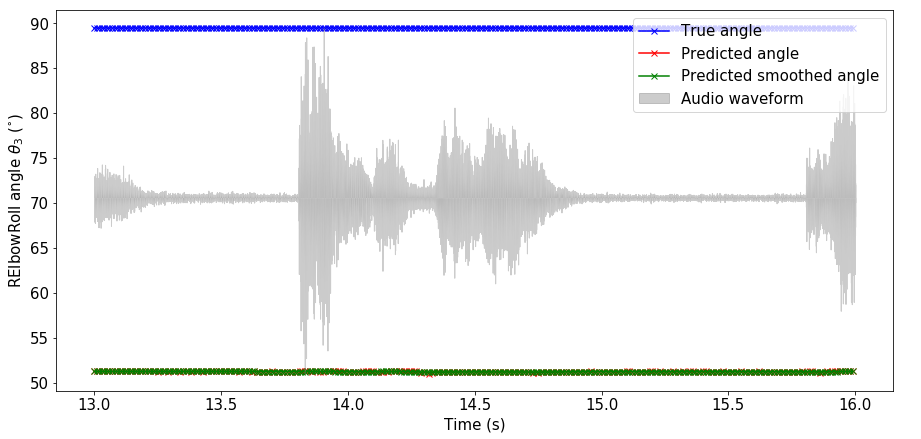

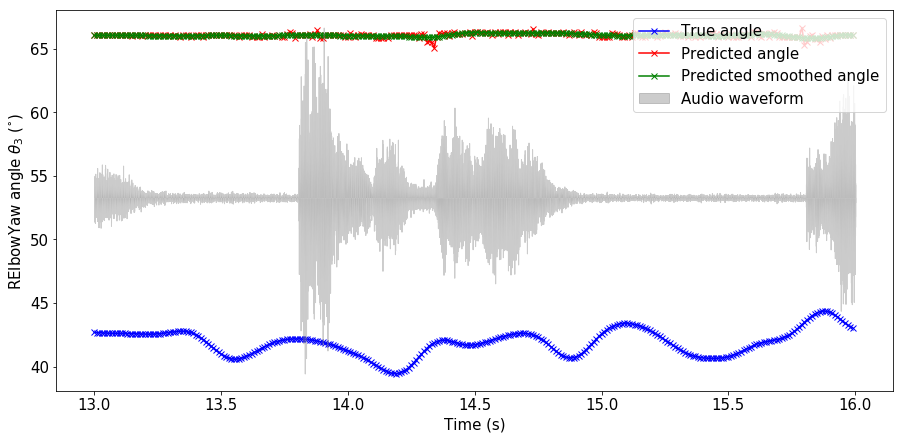

DROPOUT:  0.5
===========================================Smooth=====================


PID20Task3


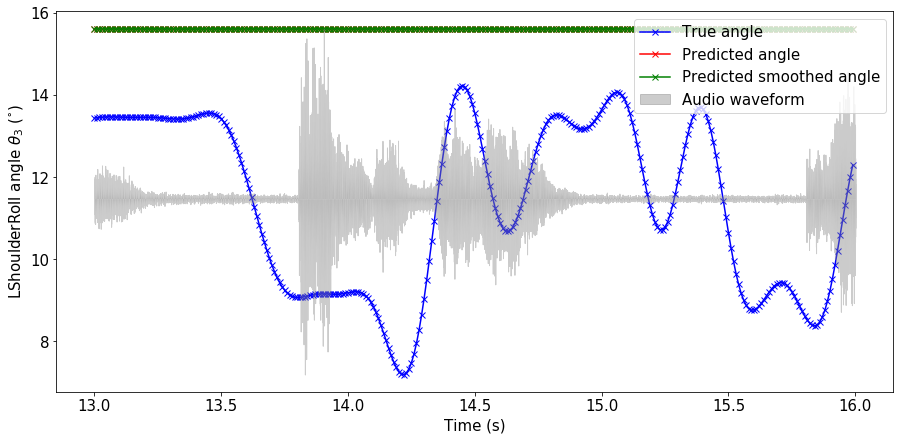

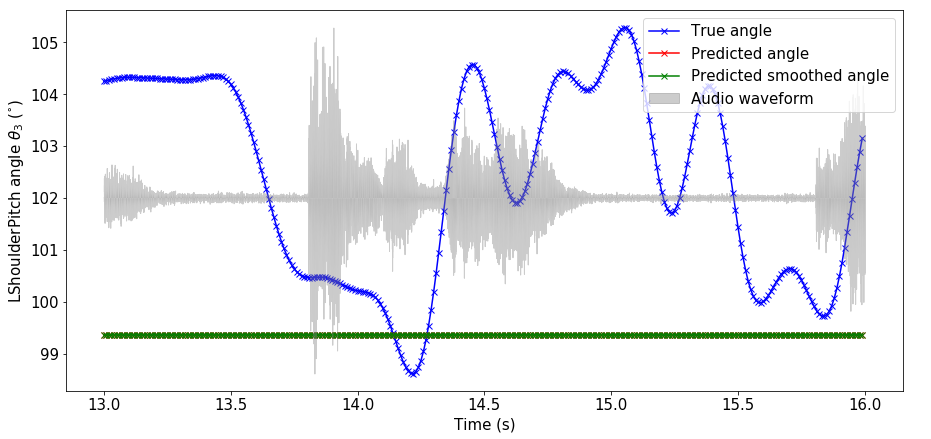

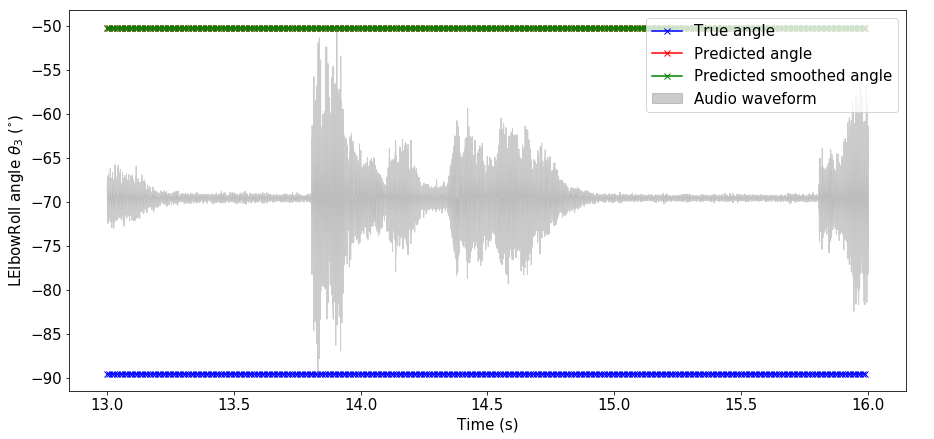

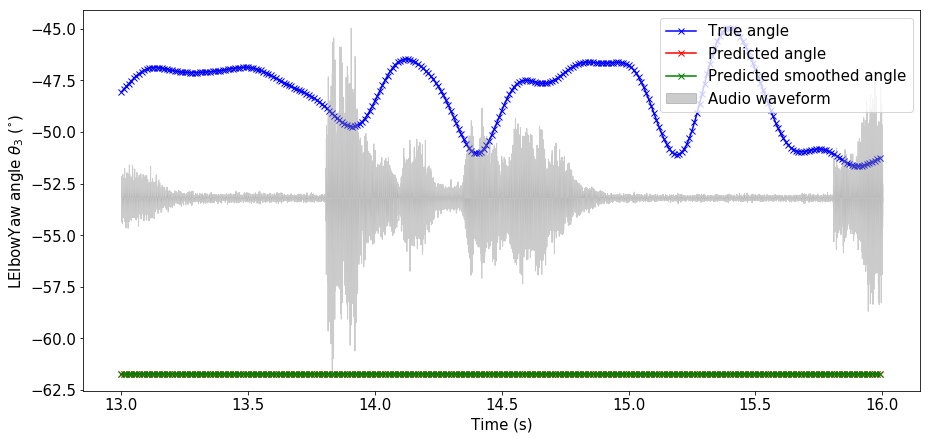

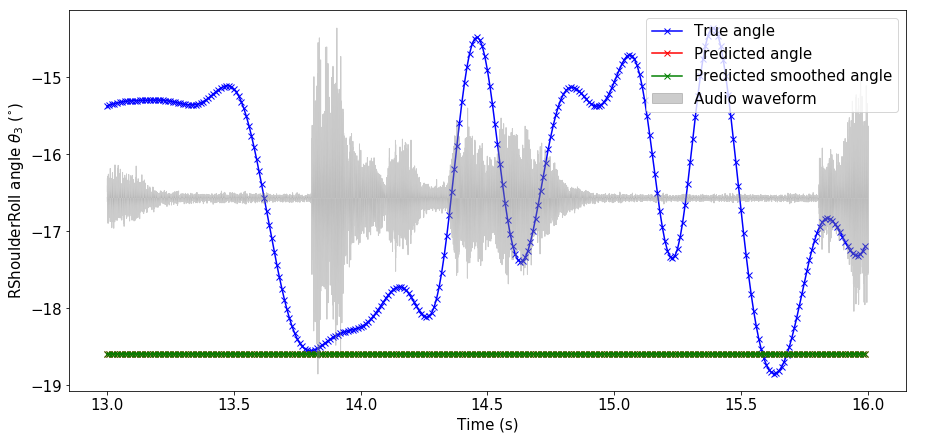

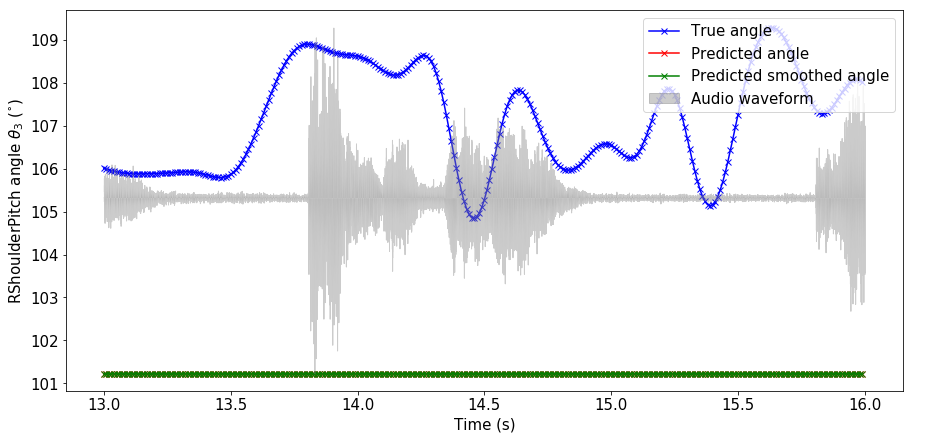

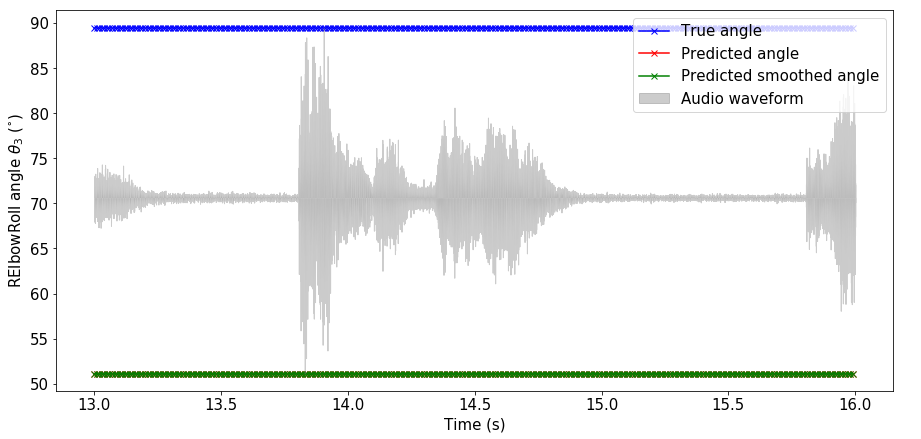

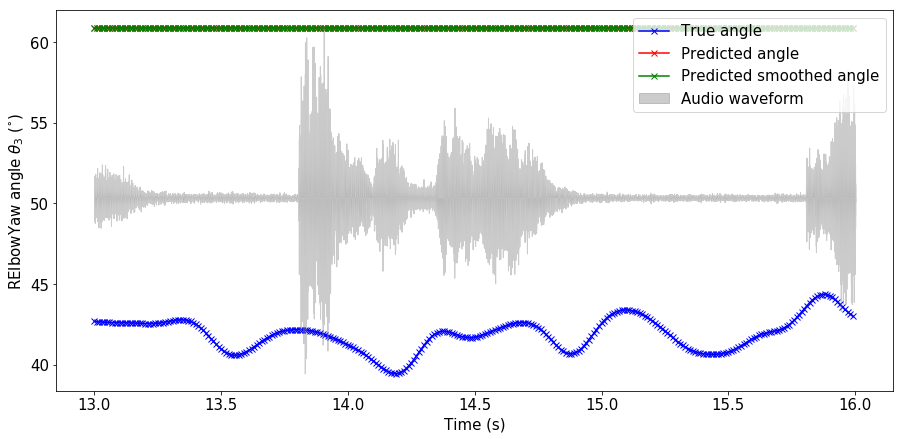

In [4]:
#######################################################################################################
# Compare dropouts - plots
#######################################################################################################

import numpy as np
import time
import glob
from evalutils import show_test_results, plot_predictions

BM = True     # use best model, not last model
# BM = False

dropouts = [
    0.,
    0.25,
    0.5
]

tuning_type = '1_35_AF26'
TE_folder = 'TrainingExamples_16kHz'

for i, dropout in enumerate(dropouts):
    
    print "DROPOUT: ", dropout
    
    if BM:
        save_results_path_prefix = './../Dataset/'+TE_folder+'/Results/MLP_SI/XXXMSBM'
    else:
        save_results_path_prefix = './../Dataset/'+TE_folder+'/Results/MLP_SI/XXXMS'
    
    if dropout == 0.:
        save_results_path_prefix = save_results_path_prefix + 'valtest_' + tuning_type
    else:
        save_results_path_prefix = save_results_path_prefix + 'DROPvaltest_' + tuning_type + '_{:.2f}'.format(dropout)

    d = np.load(save_results_path_prefix + '.npz')
    
    ###############################################################################
    # Show testing results: for raw Y and smoothed Y
    #print "===========================================Raw=====================\n"
    #show_test_results(d['results_raw'])
    print "===========================================Smooth=====================\n"
    #show_test_results(d['results_smooth'])
    print "================================================================\n"

    ###############################################################################
    # Plot predictions (post-smoothed and raw) against ground truths and audio 
#     t_VID = 1 # test VID to show
#     if t_VID >= len(d['Y_raw_list']):
#         raise ValueError("Required test VID is out of bounds!")
#     Y_true = d['Y_true_list'][t_VID]
#     Y_raw = d['Y_raw_list'][t_VID]
#     Y_smooth = d['Y_smooth_list'][t_VID]
#     test_VID = d['test_VIDs'][t_VID]

#     plot_predictions(Y_true, Y_raw, Y_smooth, 'MLP_SI', angles_to_show='all', 
#                          plot_start=13.0, plot_length=3.0, input_mode='time', SD_offset=None, 
#                          test_VID=test_VID)
    
    
    import matplotlib
    matplotlib.rcParams.update({'font.size': 15})
    # Plot predictions (post-smoothed and raw) against ground truths and audio 
    t_VID = 3 # test VID to show
    if t_VID >= len(d['Y_raw_list']):
        raise ValueError("Required test VID is out of bounds!")
    Y_true = d['Y_true_list'][t_VID]
    Y_raw = d['Y_raw_list'][t_VID]
    Y_smooth = d['Y_smooth_list'][t_VID]
    test_VID = d['test_VIDs'][t_VID]

    plot_predictions(Y_true, Y_raw, Y_smooth, 'MLP_SI', angles_to_show='hands', 
                         plot_start=13.0, plot_length=3.0, input_mode='time', SD_offset=None, 
                         test_VID=test_VID)

DROPOUT:  0.0
4 ['PID25Task2' 'PID25Task3' 'PID20Task2' 'PID20Task3']
DROPOUT:  0.25
4 ['PID25Task2' 'PID25Task3' 'PID20Task2' 'PID20Task3']
DROPOUT:  0.5
4 ['PID25Task2' 'PID25Task3' 'PID20Task2' 'PID20Task3']
MLP_SI EVALUATION ON VALIDATION SET: effect of dropout
╒═══════════╤═══════════╤═════════╤══════════════╤════════════════╤══════════════╕
│  Dropout  │   Loss    │  RMSE   │  Delta LCCA  │  LCCA (Yt,Yp)  │  Delta jerk  │
╞═══════════╪═══════════╪═════════╪══════════════╪════════════════╪══════════════╡
│     0     │ 0.0180929 │ 13.7785 │  0.0204216   │    0.97947     │   11953.4    │
├───────────┼───────────┼─────────┼──────────────┼────────────────┼──────────────┤
│   0.25    │ 0.0179502 │ 13.4629 │ 0.000978103  │    0.974748    │   11912.6    │
├───────────┼───────────┼─────────┼──────────────┼────────────────┼──────────────┤
│    0.5    │ 0.0181631 │ 13.617  │  0.0421964   │    0.955196    │    11915     │
╘═══════════╧═══════════╧═════════╧══════════════╧════════════════╧═══

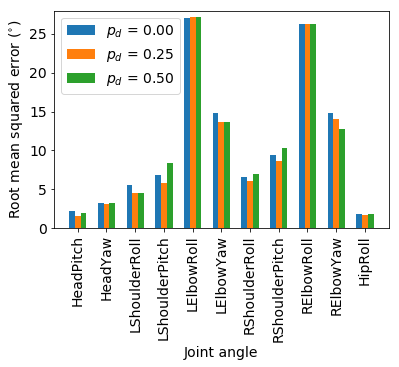

In [12]:
#######################################################################################################
# Compare dropouts - table
#######################################################################################################
import numpy as np
import time
import glob
from evalutils import show_test_results, plot_predictions, plot_4RMSE, calculate_norm_delta_jerk_onList
from tabulate import tabulate
import matplotlib.pyplot as plt

dropouts = [
    0.,
    0.25,
    0.5
]

tuning_type = '1_35_AF26'
TE_folder = 'TrainingExamples_16kHz'

save_results_path_prefix = './../Dataset/'+TE_folder+'/Results/MLP_SI/XXXMSBM'

dropout_labels = []

RMSE = []
RMSEbyAngles = []
localCCA_XYt = []
localCCA_XYp = []
localCCA_YY = []
jerk = []
jerk_delta = []
localCCA_delta = []
losses = []

for dropout in dropouts:
    
    print "DROPOUT: ", dropout
    dropout_labels.append( '$p_d$ = {:.2f}'.format(dropout) )
    
    if dropout == 0.:
        dd = np.load('./../Dataset/'+TE_folder+'/Results/MLP_SI/XXXval_' + tuning_type + '.npz')
        vals = dd['vals']
        losses.append( np.min(vals) )
        
        dd = np.load(save_results_path_prefix + 'valtest_' + tuning_type + '.npz')
    else:
        dd = np.load(save_results_path_prefix + 'DROPvaltest_' 
                     + tuning_type + '_{:.2f}'.format(dropout) + '.npz')
        losses.append( dd['test_loss'] )     

    results_smooth = dd['results_smooth']
    RMSE.append( results_smooth[1][0] ) # overall RMSE
    RMSEbyAngles.append( results_smooth[0][0] ) # RMSE by angles
    #print results_smooth[1][0], results_smooth[3]['XYt'][0], results_smooth[4]['pred']
    localCCA_XYt.append( results_smooth[3]['XYt'][0] )
    localCCA_XYp.append( results_smooth[3]['XYp'][0] )
    localCCA_YY.append( results_smooth[3]['YtYp'][0] )
    localCCA_delta.append( abs(results_smooth[3]['XYt'][0] - results_smooth[3]['XYp'][0]) )
    
    jerk.append( np.sum( results_smooth[4]['pred'] ) )
    
    # RECALCULATE DELTA JERK 
    Y_true_list = dd['Y_true_list']
    Y_pred_list = dd['Y_smooth_list']
    print len(Y_pred_list), dd['test_VIDs']
    jerk_delta.append( np.sum( calculate_norm_delta_jerk_onList(Y_true_list, Y_pred_list) ) )

    
    
#########################################################
headers = [
    'Dropout', 
    'Loss', 
    'RMSE', 
    'Delta LCCA',
    'LCCA (Yt,Yp)',
    'Delta jerk'
]
tab_data = np.concatenate(([dropouts], [losses], [RMSE], [localCCA_delta], [localCCA_YY], [jerk_delta]), axis=0).T
print "MLP_SI EVALUATION ON VALIDATION SET: effect of dropout"
print tabulate(tab_data, headers=headers, 
               tablefmt='fancy_grid', 
               #showindex=feature_sets, 
               numalign='center'
              )
print tabulate(tab_data, headers=headers, 
               tablefmt='latex_booktabs', 
               #showindex=feature_sets, 
               numalign='center'
              )

##########################################
# Show bar plot - RMSE by angles
from evalutils import angles_names
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
def plot_4RMSE(rmses_byAngles, labels, stds=[], y_max=28.):
    
    N_series = len(labels)
    N_angles = len(rmses_byAngles[0])
    xaxis = np.arange(N_angles)
    w = 0.2 # bar width
#     plt.figure(figsize=(12,4))
    plt.figure()
    for i in range(N_series):
        if len(stds) == 0:
            plt.bar(xaxis - 0.5*N_series*w + i*w, rmses_byAngles[i], width=w, align='edge', label=labels[i])
        else:
            plt.bar(xaxis - 0.5*N_series*w + i*w, rmses_byAngles[i], yerr=stds[i], width=w, align='edge', label=labels[i])
    plt.ylabel('Root mean squared error ($^{\circ}$)') #, fontsize=14)
    plt.xlabel('Joint angle')
    plt.xticks(xaxis, angles_names[:N_angles], rotation=90)
    plt.ylim(0, y_max)
    plt.legend(loc='upper left')
    plt.show()

plot_4RMSE(RMSEbyAngles, dropout_labels)